# Emotion Recognition in Speech - Data Wrangling

## Contents

* [Introduction](#Introduction)
    * [Data Science Problem](#Data_Science_Problem)
* [Imports](#Imports)
* [Objectives](#Objectives)
* [About the dataset](#About_the_dataset)
    * [Loading and Visualizing an Audio File](#Loading_and_Visualizing_an_Audio_File)
    * [Audio File information](#Audio_File_information)
    * [Playing a sample](#Playing_a_sample)
* [Vizualizing](#Vizualizing)
    * [Visualizing the Audio File](#Visualizing_the_Audio_File)
    * [Trimming the file](#Trimming_the_file)
    * [Spectrogram](#Spectrogram)
    * [Display in log-frequency](#Display_in_log-frequency)
    * [Down Sampling Test](#Down_Sampling_Test)
    * [MFCC, Chroma, Mel Test](#MFCC,_Chroma,_Mel_Test)
* [Creating a dataframe](#Creating_a_dataframe)
* [Exploring the dataframe](#Exploring_the_dataframe)
    * [Strong vs normal emotion](#Strong_vs_normal_emotion)    
    * [Number of repeated phrases](#Number_of_repeated_phrases)   
    * [Number of Male vs Female actors](#Number_of_Male_vs_Female_actors)
    * [Emotions](#Emotions)
    * [Statements](#Statements)
* [Cleaning the dataframe](#Cleaning_the_dataframe)
    * [Checking for duplicate values](#Checking_for_duplicate_values)
    * [Cleaning up outliers](#Cleaning_up_outliers)
    * [Checking for missing values](#Checking_for_missing_values)
    * [Distributions Of Feature Values](#Distributions_Of_Feature_Values)
    * [Numeric data summary](#Numeric_data_summary)
* [Exporting DataFrame](#Exporting_DataFrame)
* [Summary](#Summary)

## Introduction

This step focuses on collecting data, organizing it, and making sure it's well defined. 
Attention to these tasks will pay off greatly later on. Some data cleaning can be done at this stage, 
but it's important not to be overzealous in your cleaning before we've explored the data to better understand it.

### Data Science Problem<a id='Data_Science_Problem'></a>

The purpose of this data science project is to come up with a predictive model for emotion recognition in speech. 
We suspects it may have better responses to human / robot interaction based on categories of emotion detect 
from customers with audio-enabled bots. The categorization of the customer's emotial state can better atune a variety 
of optional responses to customize interations. This project aims to build a predictive model for emotion recognition 
based on a set of actor data that falls into 8 categories of emotional state. This model will be used to provide 
guidance for an audio-enabled bot's available responses and future customer interaction.

## Imports

In [1]:
# Importing librosa, soundfile, pandas, os, glob, pickle, numpy, matplotlib, seaborn and warnings in the lines below
import librosa
import librosa.display
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress specific FutureWarnings related to seaborn and pandas
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

load_dotenv()
sound_path = os.getenv('audio_path')

## Objectives

There are some fundamental questions to resolve in this notebook.

•Do we may have the data we need to tackle the desired question?  
      •Have we identified the required target value?   
      •Do we have potentially useful features?   
•Do we have any fundamental issues with the data?  

## About the dataset<a id='About_the_dataset'></a>

This dataset is pulled from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). It has 
classifications that are contained in the file names. They are as follows:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

Academic citation

If you use the RAVDESS in an academic publication, please use the following citation: Livingstone SR, Russo FA (2018) 
    The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and 
        vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

All other attributions

If you use the RAVDESS in a form other than an academic publication, such as in a blog post, school project, or 
non-commercial product, please use the following attribution: "The Ryerson Audio-Visual Database of Emotional Speech 
    and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

### Loading and Visualizing an Audio File<a id='Loading_and_Visualizing_an_Audio_File'></a>

In [4]:
# path of the audio file
audio_data = f'{sound_path}/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav'
# This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ
x, sr = librosa.load(audio_data, sr=22000)

# We can change this behavior by resampling at sr=44.1KHz.
# x = librosa.load(audio_data, sr=44000)

### Audio File information<a id='Audio_File_information'></a>

In [3]:
print(x.shape)
print(sr)

(72673,)
22000


### Playing a sample<a id='Playing_a_sample'></a>

In [4]:
ipd.Audio(f'{sound_path}/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav') # load a local WAV file

## Vizualizing

### Visualizing the Audio File<a id='Visualizing_the_Audio_File'></a>

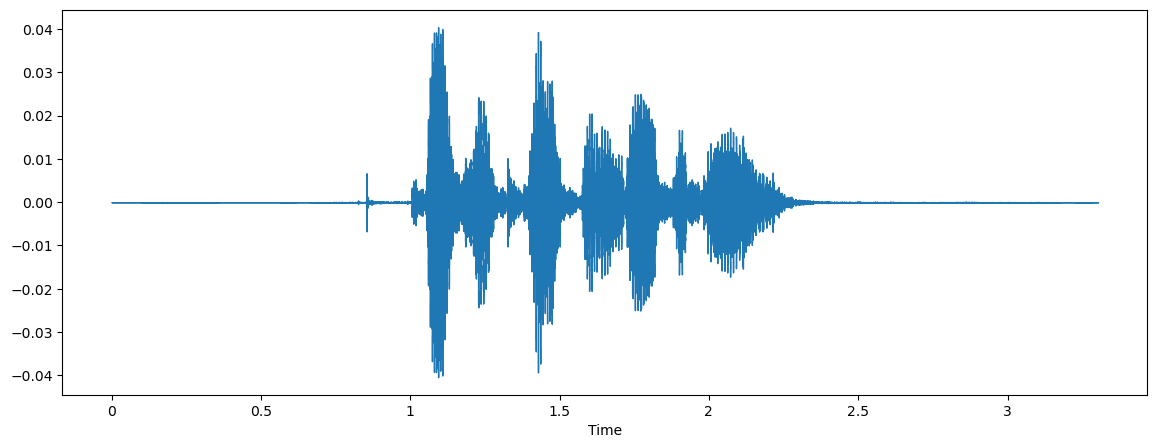

In [5]:
%matplotlib inline

plt.figure(figsize=(14, 5))
# plotting the sampled signal
librosa.display.waveshow(x, sr=sr)

### Trimming the file<a id='Trimming_the_file'></a>

In [3]:
# Define a function to load and trim audio
def load_and_trim_audio(file_path, top_db=30):
    # Load audio file
    y, sr = librosa.load(file_path)
    # Trim silence
    trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
    return trimmed_y

In [7]:
X_trimmed = load_and_trim_audio(audio_data, top_db=30)

ipd.Audio(X_trimmed, rate=22000)

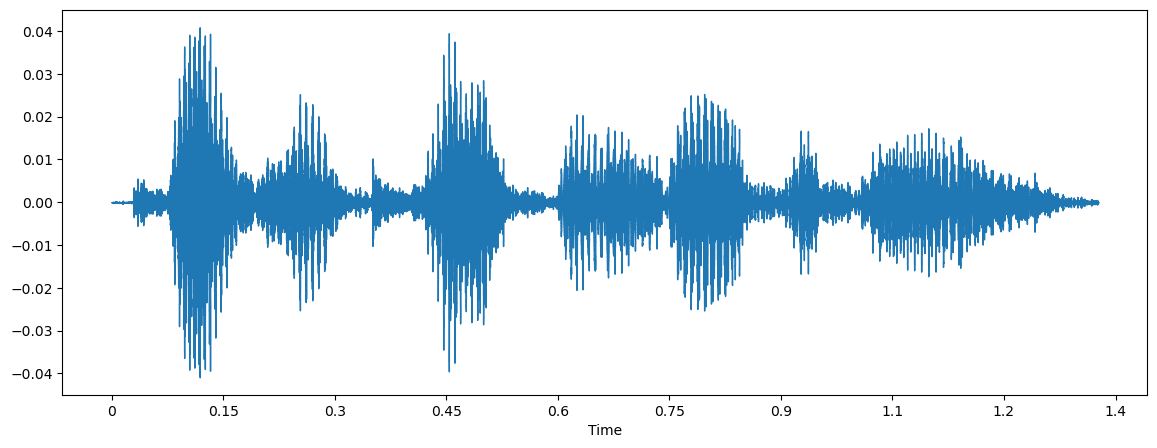

In [8]:
plt.figure(figsize=(14, 5))
# plotting the sampled signal
librosa.display.waveshow(X_trimmed, sr=sr)

### Spectrogram

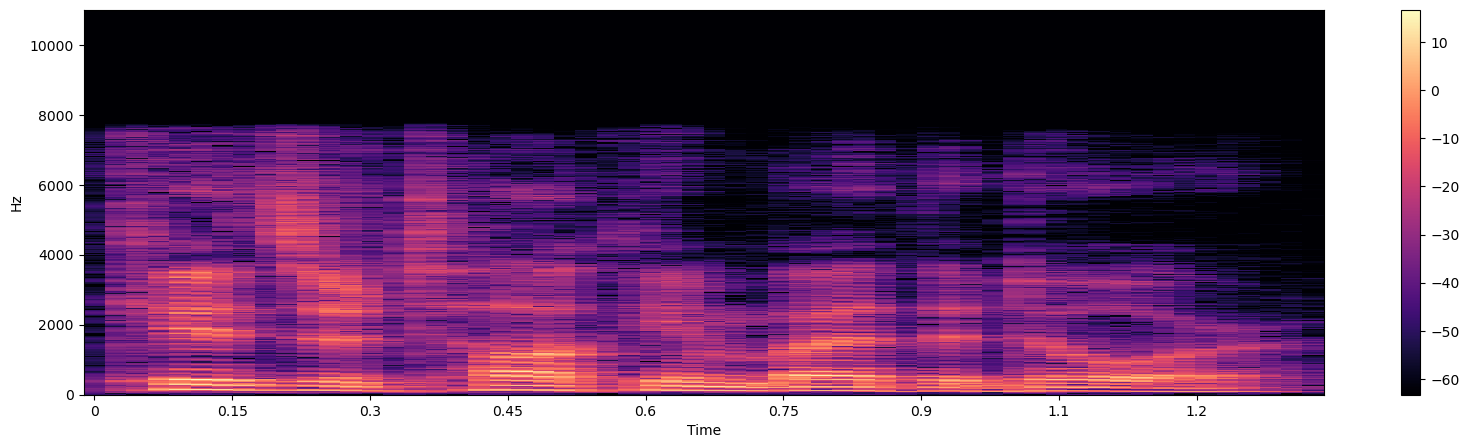

In [9]:
# x: numpy array
X = librosa.stft(X_trimmed)
# converting into energy levels(dB)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Display in log-frequency<a id='Display_in_log-frequency'></a>

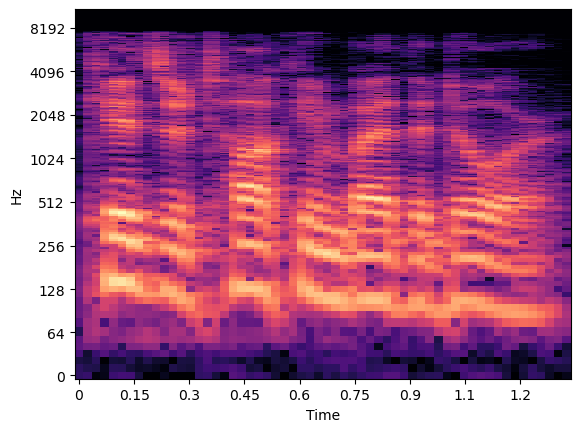

In [10]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')

### Down Sampling Test<a id='Down_Sampling_Test'></a>

In [11]:
# If you need to downsample the audio
desired_sr = 10000  # For example, to downsample to 1 kHz
x_downsampled = librosa.resample(X_trimmed, orig_sr=sr, target_sr=desired_sr)

In [12]:
ipd.Audio(x_downsampled, rate=desired_sr) # play downsampled file

### MFCC, Chroma, Mel Test<a id='MFCC,_Chroma,_Mel_Test'></a>

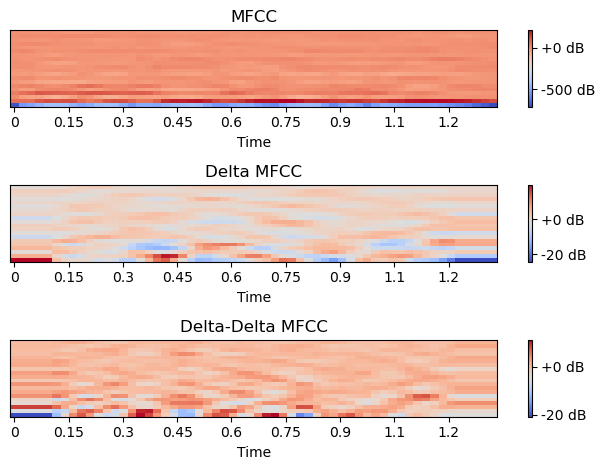

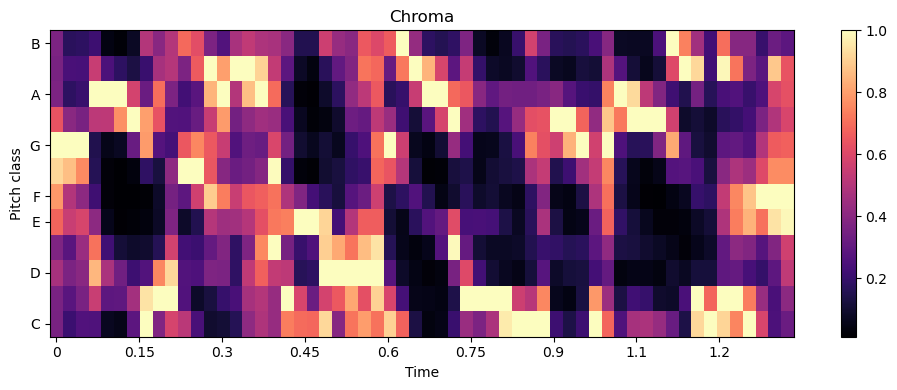

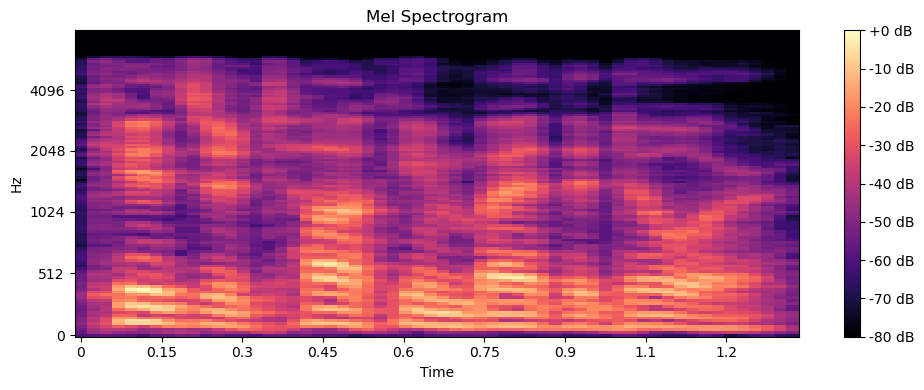

In [13]:
# Load the audio file
# audio_path = f'{sound_path}/ravdess-data/Actor_01/03-01-01-01-01-01-01.wav'
# y, sr = librosa.load(audio_path)

# Extract MFCC
mfcc = librosa.feature.mfcc(y=X_trimmed, sr=sr, n_mfcc=20)
delta_mfccs = librosa.feature.delta(mfcc)
delta2_mfccs = librosa.feature.delta(mfcc, order=2)

# Plot original MFCC
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')

# Plot Delta MFCC
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
librosa.display.specshow(delta_mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Delta MFCC')

# Plot Delta-Delta MFCC
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
librosa.display.specshow(delta2_mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Delta-Delta MFCC')

plt.tight_layout()  # Adjust layout

# Extract Chroma
chroma = librosa.feature.chroma_stft(y=X_trimmed, sr=sr)
# Display Chroma
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

# Extract Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=X_trimmed, sr=sr)
# Display Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

## Creating a dataframe<a id='Creating_a_dataframe'></a>

### Helper functions

In [5]:
# Path to sound files
file_pattern = f'{sound_path}/ravdess-data/Actor_*/*.wav'

# Extracts orginial file name as a helper to other functions
def extract_original_filename(filename):
    return filename.split('_part_')[0]

# Define a function to load and trim audio
def load_and_trim_audio(file_path, top_db=20):
    # Load audio file
    y, sr = librosa.load(file_path)
    # Trim silence
    trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
    return trimmed_y

# Determines if split part is silent for another function to drop
def is_silent(y, threshold=0.001):
    return np.std(y) < threshold

# Define the determine_modality function
def determine_modality(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[0].rstrip('.wav'))
        if number % 3 == 1:
            return 1
        elif number % 3 == 2:
            return 2
        else:
            return 3
    except Exception as e:
        # print(f"Error in determine_modality: {e}")
        return 'Unknown'

# Define the determine_voice_channel function
def determine_voice_channel(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[1].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_voice_channel: {e}")
        return 'Unknown'


# Define the dertermine_emotion function
def determine_emotion(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[2].rstrip('.wav'))
        if number % 8 == 1:
            return 1
        elif number % 8 == 2:
            return 2
        elif number % 8 == 3:
            return 3
        elif number % 8 == 4:
            return 4
        elif number % 8 == 5:
            return 5
        elif number % 8 == 6:
            return 6
        elif number % 8 == 7:
            return 7
        else:
            return 8
    except Exception as e:
        # print(f"Error in determine_emotion: {e}")
        return 'Unknown'


# Define the determine_intensity function
def determine_intensity(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[3].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_intensity: {e}")
        return 'Unknown'

# Define the determine_statement function
def determine_statement(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[4].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_statement: {e}")
        return 'Unknown'

# Define the determine_repetition function
def determine_repetition(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[5].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_repetition: {e}")
        return 'Unknown'
    
# Define the determine_gender function
def determine_gender(filename):
    try:
        number = int(extract_original_filename(filename).split('-')[6].rstrip('.wav'))
        return 1 if number % 2 == 1 else 2
    except Exception as e:
        # print(f"Error in determine_gender: {e}")
        return 'Unknown'

def split_and_process(file_path):
    y, sr = librosa.load(file_path, sr=None)
    segment_length = len(y) // 3  # Adjust number of segments as needed, current is 3

    segments_data = []
    for i in range(3):  # Adjust number of segments as needed, current is 3
        start = i * segment_length
        end = None if i == 2 else (i + 1) * segment_length  # Adjust number of segments as needed, current is 3
        segment = y[start:end]

        modified_filename = f"{os.path.basename(file_path).rstrip('.wav')}_part_{chr(97 + i)}.wav"

        if is_silent(segment, threshold=0.001):
            silent_data.append({'filename': modified_filename, 'is_silent': True})
            continue  # Skip processing this segment

        features = extract_features(segment, sr, modified_filename)
        segments_data.append(features)

    return segments_data

In [17]:
# Empty data set
data = []

# For loop to iterate over files
for file_path in glob.glob(file_pattern):
    try:
        # Extract just the .wav file name
        filename = os.path.basename(file_path)
        
        # Load each individual file
        y = load_and_trim_audio(file_path)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T
        delta_mfccs = librosa.feature.delta(mfcc).T
        delta2_mfccs = librosa.feature.delta(mfcc, order=2).T
        chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr).T
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).T
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr).T
        roll_off = librosa.feature.spectral_rolloff(y=y, sr=sr).T
        rms = librosa.feature.rms(y=y).T
        zero_cr = librosa.feature.zero_crossing_rate(y=y).T
    
        features = {
            'filename': filename,
            'modality': determine_modality(filename),
            'vocal_channel': determine_voice_channel(filename),
            'emotion': determine_emotion(filename),
            'voice_intensity': determine_intensity(filename),
            'statement': determine_statement(filename),
            'statement_repetition': determine_repetition(filename),
            'actor_gender': determine_gender(filename),
            'mfcc_mean': mfcc.mean().mean(),
            'mfcc_max': mfcc.max().mean(),
            'mfcc_min': mfcc.min().mean(),
            'mfcc_median': np.median(mfcc).mean(),
            'mfcc_std': np.std(mfcc).mean(),
            'mfcc_skew': scipy.stats.skew(mfcc).mean(),
            'mfcc_kurtosis': scipy.stats.kurtosis(mfcc).mean(),
            'mfcc_delta_mean': delta_mfccs.mean().mean(),
            'mfcc_delta_max': delta_mfccs.max().mean(),
            'mfcc_delta_min': delta_mfccs.min().mean(),
            'mfcc_delta_median': np.median(delta_mfccs).mean(),
            'mfcc_delta_std': np.std(delta_mfccs).mean(),
            'mfcc_delta_skew': scipy.stats.skew(delta_mfccs).mean(),
            'mfcc_delta_kurtosis': scipy.stats.kurtosis(delta_mfccs).mean(),
            'mfcc_delta2_mean': delta2_mfccs.mean().mean(),
            'mfcc_delta2_max': delta2_mfccs.max().mean(),
            'mfcc_delta2_min': delta2_mfccs.min().mean(),
            'mfcc_delta2_median': np.median(delta2_mfccs).mean(),
            'mfcc_delta2_std': np.std(delta2_mfccs).mean(),
            'mfcc_delta2_skew': scipy.stats.skew(delta2_mfccs).mean(),
            'mfcc_delta2_kurtosis': scipy.stats.kurtosis(delta2_mfccs).mean(),
            'chroma_mean': chroma.mean().mean(),
            'chroma_min': chroma.min().mean(),
#            'chroma_max': chroma.max().mean(),    # always returned a 1
            'chroma_median': np.median(chroma).mean(),
            'chroma_std': np.std(chroma).mean(),
            'chroma_skew': scipy.stats.skew(chroma).mean(),
            'chroma_kurtosis': scipy.stats.kurtosis(chroma).mean(),
            'mel_mean': mel_spectrogram.mean().mean(),
            'mel_max': mel_spectrogram.max().mean(),
            'mel_min': mel_spectrogram.min().mean(),
            'mel_median': np.median(mel_spectrogram).mean(),
            'mel_std': np.std(mel_spectrogram).mean(),
            'mel_skew': scipy.stats.skew(mel_spectrogram).mean(),
            'mel_kurtosis': scipy.stats.kurtosis(mel_spectrogram).mean(),
            'contrast_mean': spectral_contrast.mean().mean(),
            'contrast_max': spectral_contrast.max().mean(),
            'contrast_min': spectral_contrast.min().mean(),
            'contrast_median': np.median(spectral_contrast).mean(),
            'contrast_std': np.std(spectral_contrast).mean(),
            'contrast_skew': scipy.stats.skew(spectral_contrast).mean(),
            'contrast_kurtosis': scipy.stats.kurtosis(spectral_contrast).mean(),
            'centroid_mean': centroid.mean().mean(),
            'centroid_max': centroid.max().mean(),
            'centroid_min': centroid.min().mean(),
            'centroid_median': np.median(centroid).mean(),
            'centroid_std': np.std(centroid).mean(),
            'centroid_skew': scipy.stats.skew(centroid).mean(),
            'centroid_kurtosis': scipy.stats.kurtosis(centroid).mean(),
            'roll_off_mean': roll_off.mean().mean(),
            'roll_off_max': roll_off.max().mean(),
            'roll_off_min': roll_off.min().mean(),
            'roll_off_median': np.median(roll_off).mean(),
            'roll_off_std': np.std(roll_off).mean(),
            'roll_off_skew': scipy.stats.skew(roll_off).mean(),
            'roll_off_kurtosis': scipy.stats.kurtosis(roll_off).mean(),
            'rms_mean': rms.mean().mean(),
            'rms_max': rms.max().mean(),
            'rms_min': rms.min().mean(),
            'rms_median': np.median(rms).mean(),
            'rms_std': np.std(rms).mean(),
            'rms_skew': scipy.stats.skew(rms).mean(),
            'rms_kurtosis': scipy.stats.kurtosis(rms).mean(),
            'zero_cr_mean': zero_cr.mean().mean(),
            'zero_cr_max': zero_cr.max().mean(),
            'zero_cr_min': zero_cr.min().mean(),
            'zero_cr_median': np.median(zero_cr).mean(),
            'zero_cr_std': np.std(zero_cr).mean(),
            'zero_cr_skew': scipy.stats.skew(zero_cr).mean(),
            'zero_cr_kurtosis': scipy.stats.kurtosis(zero_cr).mean(),
                     
        }

        data.append(features)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# for file_path in glob.glob(file_pattern):
#     try:
#         segments_features = split_and_process(file_path)
#         data.extend(segments_features)
#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

                   filename  modality  vocal_channel  emotion  \
0  03-01-01-01-01-01-01.wav         3              1        1   
1  03-01-01-01-01-02-01.wav         3              1        1   
2  03-01-01-01-02-01-01.wav         3              1        1   
3  03-01-01-01-02-02-01.wav         3              1        1   
4  03-01-02-01-01-01-01.wav         3              1        2   

   voice_intensity  statement  statement_repetition  actor_gender  mfcc_mean  \
0                1          1                     1             1 -13.750966   
1                1          1                     2             1 -14.013200   
2                1          2                     1             1 -13.286643   
3                1          2                     2             1 -13.380160   
4                1          1                     1             1 -14.227764   

     mfcc_max  ...   rms_std  rms_skew  rms_kurtosis  zero_cr_mean  \
0  208.771698  ...  0.002752  0.523488     -0.223807      

In [49]:
df['chroma_max'].sum()

1440.0

In [16]:
# # Empty data set
# data = []

# # For loop to iterate over files
# for file_path in glob.glob(file_pattern):
#     try:
#         # Extract just the .wav file name
#         filename = os.path.basename(file_path)
        
#         # Load each individual file
#         y = load_and_trim_audio(file_path)
        
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#         delta_mfccs = librosa.feature.delta(mfcc)
#         delta2_mfccs = librosa.feature.delta(mfcc, order=2)
#         chroma = librosa.feature.chroma_stft(y=y, sr=sr)
#         mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#         spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#         centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
#         roll_off = librosa.feature.spectral_rolloff(y=y, sr=sr)
#         rms = librosa.feature.rms(y=y)
#         zero_cr = librosa.feature.zero_crossing_rate(y=y)
    
#         features = {
#             'filename': filename,
#             'modality': determine_modality(filename),
#             'vocal_channel': determine_voice_channel(filename),
#             'emotion': determine_emotion(filename),
#             'voice_intensity': determine_intensity(filename),
#             'statement': determine_statement(filename),
#             'statement_repetition': determine_repetition(filename),
#             'actor_gender': determine_gender(filename),
#             'mfcc_mean': mfcc.mean(axis=1).mean(),
#             'mfcc_max': mfcc.max(axis=1).mean(),
#             'mfcc_min': mfcc.min(axis=1).mean(),
#             'mfcc_median': np.median(mfcc, axis=1).mean(),
#             'mfcc_std': np.std(mfcc, axis=1).mean(),
#             'mfcc_skew': scipy.stats.skew(mfcc, axis=1).mean(),
#             'mfcc_kurtosis': scipy.stats.kurtosis(mfcc, axis=1).mean(),
#             'mfcc_delta_mean': delta_mfccs.mean(axis=1).mean(),
#             'mfcc_delta_max': delta_mfccs.max(axis=1).mean(),
#             'mfcc_delta_min': delta_mfccs.min(axis=1).mean(),
#             'mfcc_delta_median': np.median(delta_mfccs, axis=1).mean(),
#             'mfcc_delta_std': np.std(delta_mfccs, axis=1).mean(),
#             'mfcc_delta_skew': scipy.stats.skew(delta_mfccs, axis=1).mean(),
#             'mfcc_delta_kurtosis': scipy.stats.kurtosis(delta_mfccs, axis=1).mean(),
#             'mfcc_delta2_mean': delta2_mfccs.mean(axis=1),
#             'mfcc_delta2_max': delta2_mfccs.max(axis=1).mean(),
#             'mfcc_delta2_min': delta2_mfccs.min(axis=1).mean(),
#             'mfcc_delta2_median': np.median(delta2_mfccs, axis=1).mean(),
#             'mfcc_delta2_std': np.std(delta2_mfccs, axis=1).mean(),
#             'mfcc_delta2_skew': scipy.stats.skew(delta2_mfccs, axis=1).mean(),
#             'mfcc_delta2_kurtosis': scipy.stats.kurtosis(delta2_mfccs, axis=1).mean(),
#             'chroma_mean': chroma.mean(axis=1),
#             'chroma_min': chroma.min(axis=1).mean(),
#             'chroma_max': chroma.max(axis=1).mean(),
#             'chroma_median': np.median(chroma, axis=1).mean(),
#             'chroma_std': np.std(chroma, axis=1).mean(),
#             'chroma_skew': scipy.stats.skew(chroma, axis=1).mean(),
#             'chroma_kurtosis': scipy.stats.kurtosis(chroma, axis=1).mean(),
#             'mel_mean': mel_spectrogram.mean(axis=1),
#             'mel_max': mel_spectrogram.max(axis=1).mean(),
#             'mel_min': mel_spectrogram.min(axis=1).mean(),
#             'mel_median': np.median(mel_spectrogram, axis=1).mean(),
#             'mel_std': np.std(mel_spectrogram, axis=1).mean(),
#             'mel_skew': scipy.stats.skew(mel_spectrogram, axis=1).mean(),
#             'mel_kurtosis': scipy.stats.kurtosis(mel_spectrogram, axis=1).mean(),
#             'contrast_mean': spectral_contrast.mean(axis=1),
#             'contrast_max': spectral_contrast.max(axis=1).mean(),
#             'contrast_min': spectral_contrast.min(axis=1).mean(),
#             'contrast_median': np.median(spectral_contrast, axis=1).mean(),
#             'contrast_std': np.std(spectral_contrast, axis=1).mean(),
#             'contrast_skew': scipy.stats.skew(spectral_contrast, axis=1).mean(),
#             'contrast_kurtosis': scipy.stats.kurtosis(spectral_contrast, axis=1).mean(),
#             'centroid_mean': centroid.mean(axis=1),
#             'centroid_max': centroid.max(axis=1).mean(),
#             'centroid_min': centroid.min(axis=1).mean(),
#             'centroid_median': np.median(centroid, axis=1).mean(),
#             'centroid_std': np.std(centroid, axis=1).mean(),
#             'centroid_skew': scipy.stats.skew(centroid, axis=1).mean(),
#             'centroid_kurtosis': scipy.stats.kurtosis(centroid, axis=1).mean(),
#             'roll_off_mean': roll_off.mean(axis=1),
#             'roll_off_max': roll_off.max(axis=1).mean(),
#             'roll_off_min': roll_off.min(axis=1).mean(),
#             'roll_off_median': np.median(roll_off, axis=1).mean(),
#             'roll_off_std': np.std(roll_off, axis=1).mean(),
#             'roll_off_skew': scipy.stats.skew(roll_off, axis=1).mean(),
#             'roll_off_kurtosis': scipy.stats.kurtosis(roll_off, axis=1).mean(),
#             'rms_mean': rms.mean(axis=1),
#             'rms_max': rms.max(axis=1).mean(),
#             'rms_min': rms.min(axis=1).mean(),
#             'rms_median': np.median(rms, axis=1).mean(),
#             'rms_std': np.std(rms, axis=1).mean(),
#             'rms_skew': scipy.stats.skew(rms, axis=1).mean(),
#             'rms_kurtosis': scipy.stats.kurtosis(rms, axis=1).mean(),
#             'zero_cr_mean': zero_cr.mean(axis=1),
#             'zero_cr_max': zero_cr.max(axis=1).mean(),
#             'zero_cr_min': zero_cr.min(axis=1).mean(),
#             'zero_cr_median': np.median(zero_cr, axis=1).mean(),
#             'zero_cr_std': np.std(zero_cr, axis=1).mean(),
#             'zero_cr_skew': scipy.stats.skew(zero_cr, axis=1).mean(),
#             'zero_cr_kurtosis': scipy.stats.kurtosis(zero_cr, axis=1).mean()
                     
#         }

#         data.append(features)
#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")

# # for file_path in glob.glob(file_pattern):
# #     try:
# #         segments_features = split_and_process(file_path)
# #         data.extend(segments_features)
# #     except Exception as e:
# #         print(f"Error processing file {file_path}: {e}")

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Display the DataFrame
# print(df.head())


In [15]:
df.shape

(1440, 78)

In [30]:
df.iloc[140: 150, 40: 45]

,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max
140,0.050753,4.511223,23.068275,25.456963,82.875013
141,0.039551,5.071084,30.413864,24.465740,79.704453
142,0.142772,4.531633,24.257114,26.178214,80.435673
143,0.096687,4.469854,23.903023,25.630512,80.070582
144,1.441697,5.469248,35.591858,24.270542,79.024044
145,2.549923,5.257108,33.145126,23.871678,78.592442
146,4.877256,5.346050,33.497955,24.990386,80.590772
147,2.089249,4.406446,23.296713,26.310816,80.950407
148,0.051202,5.196118,30.386913,24.192217,79.305663
149,0.963719,4.727334,26.194216,25.926887,82.899615


In [16]:
# df.shape  # shape with 4 parts after dropping silent segments (3276, 53)

In [17]:
# Function used is above, saving for archive
# def split_and_process(file_path):
#     y, sr = librosa.load(file_path, sr=None)
#     segment_length = len(y) // 3  # Adjust number of segments as needed, current is 3

#     segments_data = []
#     for i in range(3):  # Adjust number of segments as needed, current is 3
#         start = i * segment_length
#         end = None if i == 2 else (i + 1) * segment_length  # Adjust number of segments as needed, current is 3
#         segment = y[start:end]

#         modified_filename = f"{os.path.basename(file_path).rstrip('.wav')}_part_{chr(97 + i)}.wav"

#         if is_silent(segment, threshold=0.001):
#             silent_data.append({'filename': modified_filename, 'is_silent': True})
#             continue  # Skip processing this segment

#         features = extract_features(segment, sr, modified_filename)
#         segments_data.append(features)

#     return segments_data

In [18]:
# Function used is above, saving for archive
# def split_and_process(file_path):
#     y, sr = librosa.load(file_path, sr=None)
#     segment_length = len(y) // 4  # Adjust number of segments as needed, current is 4

#     segments_data = []
#     for i in range(4):  # Adjust number of segments as needed, current is 4
#         start = i * segment_length
#         end = None if i == 3 else (i + 1) * segment_length  # Adjust number of segments as needed, current is 4
#         segment = y[start:end]

#         modified_filename = f"{os.path.basename(file_path).rstrip('.wav')}_part_{chr(97 + i)}.wav"

#         if is_silent(segment, threshold=0.001):
#             silent_data.append({'filename': modified_filename, 'is_silent': True})
#             continue  # Skip processing this segment

#         features = extract_features(segment, sr, modified_filename)
#         segments_data.append(features)

#     return segments_data

## Exploring the dataframe<a id='Exploring_the_dataframe'></a>

### Strong vs normal emotion<a id='Strong_vs_normal_emotion'></a>

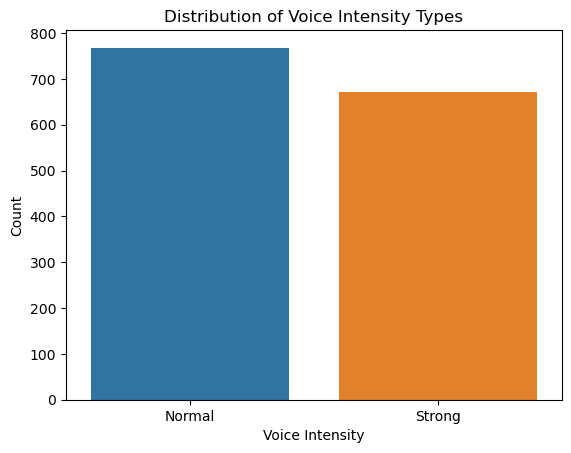

In [21]:
# Replace 1 and 2 with 'Normal' and 'Strong' in the 'voice_intensity' column
# df['voice_intensity'] = df['voice_intensity'].replace({1: 'Normal', 2: 'Strong'})

# Create a count plot
sns.countplot(x='voice_intensity', data=df)

# Adding labels and title for clarity
plt.xlabel('Voice Intensity')
plt.ylabel('Count')
plt.title('Distribution of Voice Intensity Types')
plt.xticks([0, 1], ['Normal', 'Strong'])

# Display the plot
plt.show()

### Number of repeated phrases<a id='Number_of_repeated_phrases'></a>

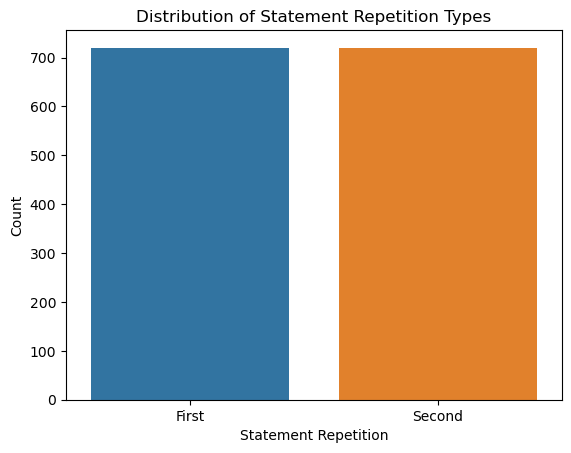

In [22]:
# Replace 1 and 2 with 'First' and 'Second' in the 'statement_repetition' column
# df['statement_repetition'] = df['statement_repetition'].replace({1: 'First', 2: 'Second'})

# Create a count plot
sns.countplot(x='statement_repetition', data=df)

# Adding labels and title for clarity
plt.xlabel('Statement Repetition')
plt.ylabel('Count')
plt.title('Distribution of Statement Repetition Types')
plt.xticks([0, 1], ['First', 'Second'])

# Display the plot
plt.show()


### Number of Male vs Female actors<a id='Number_of_Male_vs_Female_actors'></a>

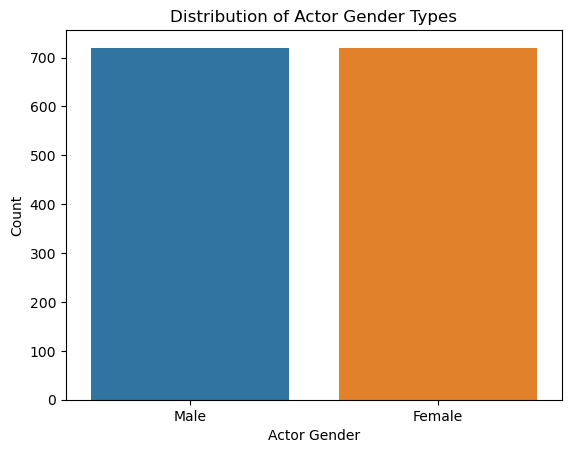

In [23]:
# Replace 1 and 2 with 'Male' and 'Female' in the 'actor_gender' column
# df['actor_gender'] = df['actor_gender'].replace({1: 'Male', 2: 'Female'})

# Create a count plot
sns.countplot(x='actor_gender', data=df)

# Adding labels and title for clarity
plt.xlabel('Actor Gender')
plt.ylabel('Count')
plt.title('Distribution of Actor Gender Types')
plt.xticks([0, 1], ['Male', 'Female'])

# Display the plot
plt.show()

### Emotions

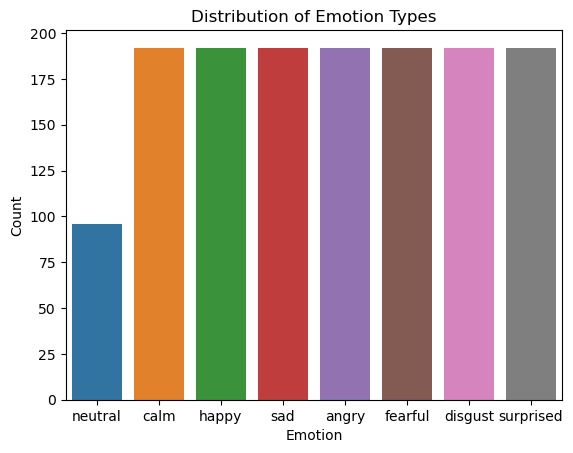

In [24]:
# Create a count plot
sns.countplot(x='emotion', data=df)

# Adding labels and title for clarity
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotion Types')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])

# Display the plot
plt.show()

In [6]:
neutral = df[df['emotion'] == 1].sum
print(neutral)

<bound method NDFrame._add_numeric_operations.<locals>.sum of                       filename  modality  vocal_channel  emotion  \
0     03-01-01-01-01-01-01.wav         3              1        1   
1     03-01-01-01-01-02-01.wav         3              1        1   
2     03-01-01-01-02-01-01.wav         3              1        1   
3     03-01-01-01-02-02-01.wav         3              1        1   
60    03-01-01-01-01-01-02.wav         3              1        1   
...                        ...       ...            ...      ...   
1323  03-01-01-01-02-02-23.wav         3              1        1   
1380  03-01-01-01-01-01-24.wav         3              1        1   
1381  03-01-01-01-01-02-24.wav         3              1        1   
1382  03-01-01-01-02-01-24.wav         3              1        1   
1383  03-01-01-01-02-02-24.wav         3              1        1   

      voice_intensity  statement  statement_repetition  actor_gender  \
0                   1          1                 

### Statements

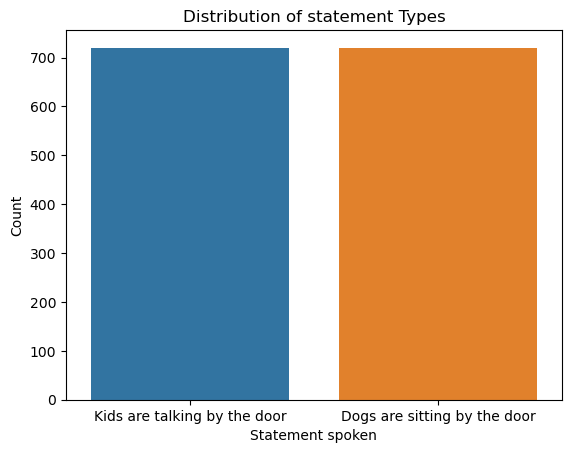

In [25]:
# Create a count plot
sns.countplot(x='statement', data=df)

# Adding labels and title for clarity
plt.xlabel('Statement spoken')
plt.ylabel('Count')
plt.title('Distribution of statement Types')
plt.xticks([0, 1], ["Kids are talking by the door", "Dogs are sitting by the door"])

# Display the plot
plt.show()

## Cleaning the dataframe<a id='Cleaning_the_dataframe'></a>

### Checking for duplicate values<a id='Checking_for_duplicate_values'></a>

In [31]:
# Checking for unique row data
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows.shape[0])

Number of duplicate rows:  0


In [22]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion', 'voice_intensity',
       'statement', 'statement_repetition', 'actor_gender', 'mfcc_mean',
       'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std', 'mfcc_skew',
       'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max', 'mfcc_delta_min',
       'mfcc_delta_median', 'mfcc_delta_std', 'mfcc_delta_skew',
       'mfcc_delta_kurtosis', 'mfcc_delta2_mean', 'mfcc_delta2_max',
       'mfcc_delta2_min', 'mfcc_delta2_median', 'mfcc_delta2_std',
       'mfcc_delta2_skew', 'mfcc_delta2_kurtosis', 'chroma_mean', 'chroma_min',
       'chroma_max', 'chroma_median', 'chroma_std', 'chroma_skew',
       'chroma_kurtosis', 'mel_mean', 'mel_max', 'mel_min', 'mel_median',
       'mel_std', 'mel_skew', 'mel_kurtosis', 'contrast_mean', 'contrast_max',
       'contrast_min', 'contrast_median', 'contrast_std', 'contrast_skew',
       'contrast_kurtosis', 'centroid_mean', 'centroid_max', 'centroid_min',
       'centroid_median', 'centroid_std', 'cen

In [32]:
# Checking for duplicate column data / files
key_columns = ['filename']
duplicate_rows = df[df.duplicated(subset=key_columns)]
print("Number of duplicate rows based on key columns: ", duplicate_rows.shape[0])

Number of duplicate rows based on key columns:  0


### Cleaning up outliers

<Axes: xlabel='mfcc_mean'>

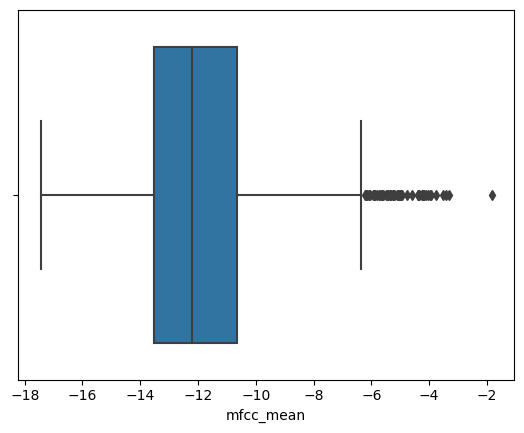

In [33]:
df['mfcc_mean'].describe()

sns.boxplot(x = df['mfcc_mean'])

In [25]:
df.shape

(1440, 78)

In [26]:
# Creating a copy of the original dataframe to preserve it
df_f = df.copy()

# Iterating over columns starting from the 7th column (index 6)
for column in df_f.columns[8:]:
    Q1 = df_f[column].quantile(0.25)
    Q3 = df_f[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df_f[column] >= Q1 - 8 * IQR) & (df_f[column] <= Q3 + 8 * IQR)
    df_f = df_f[filter]

# 'filtered_df' now has outliers removed from the last 47 columns
# 'df' remains unchanged for comparison

In [27]:
# Due to the loss of data size, both sets are preserved and performance will be run in tandem
df_f.shape

(1035, 78)

### Checking for missing values<a id='Checking_for_missing_values'></a>

In [36]:
# Getting a total of missing values
miss_val = df.isnull().sum().sum()
# filtered_miss_val = df_f.isnull().sum()

# Printing missing values
print(f"Total number of missing values: {miss_val}")

Total number of missing values: 14


In [38]:
# Select only numeric columns for the isinf check
numeric_df = df.select_dtypes(include=[np.number])

# Count the total number of infinite values (both positive and negative) in the numeric columns
infinite_values_count = np.isinf(numeric_df).values.sum()

# Print the count
print(f"Total number of infinite values in numeric columns: {infinite_values_count}")

Total number of infinite values in numeric columns: 18


In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    missing_values = df.isna().any()
    print(missing_values)

filename                False
modality                False
vocal_channel           False
emotion                 False
voice_intensity         False
statement               False
statement_repetition    False
actor_gender            False
mfcc_mean               False
mfcc_max                False
mfcc_min                False
mfcc_median             False
mfcc_std                False
mfcc_skew               False
mfcc_kurtosis           False
mfcc_delta_mean         False
mfcc_delta_max          False
mfcc_delta_min          False
mfcc_delta_median       False
mfcc_delta_std          False
mfcc_delta_skew         False
mfcc_delta_kurtosis     False
mfcc_delta2_mean        False
mfcc_delta2_max         False
mfcc_delta2_min         False
mfcc_delta2_median      False
mfcc_delta2_std         False
mfcc_delta2_skew        False
mfcc_delta2_kurtosis    False
chroma_mean             False
chroma_min              False
chroma_max              False
chroma_median           False
chroma_std

In [40]:
# Check for infinite values and replace them with NaN, which can then be imputed or removed
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [41]:
# Filling in missing values with the mean
df['mel_kurtosis'].fillna(df['mel_kurtosis'].mean(), inplace=True)

### Distributions Of Feature Values<a id='Distributions_Of_Feature_Values'></a>

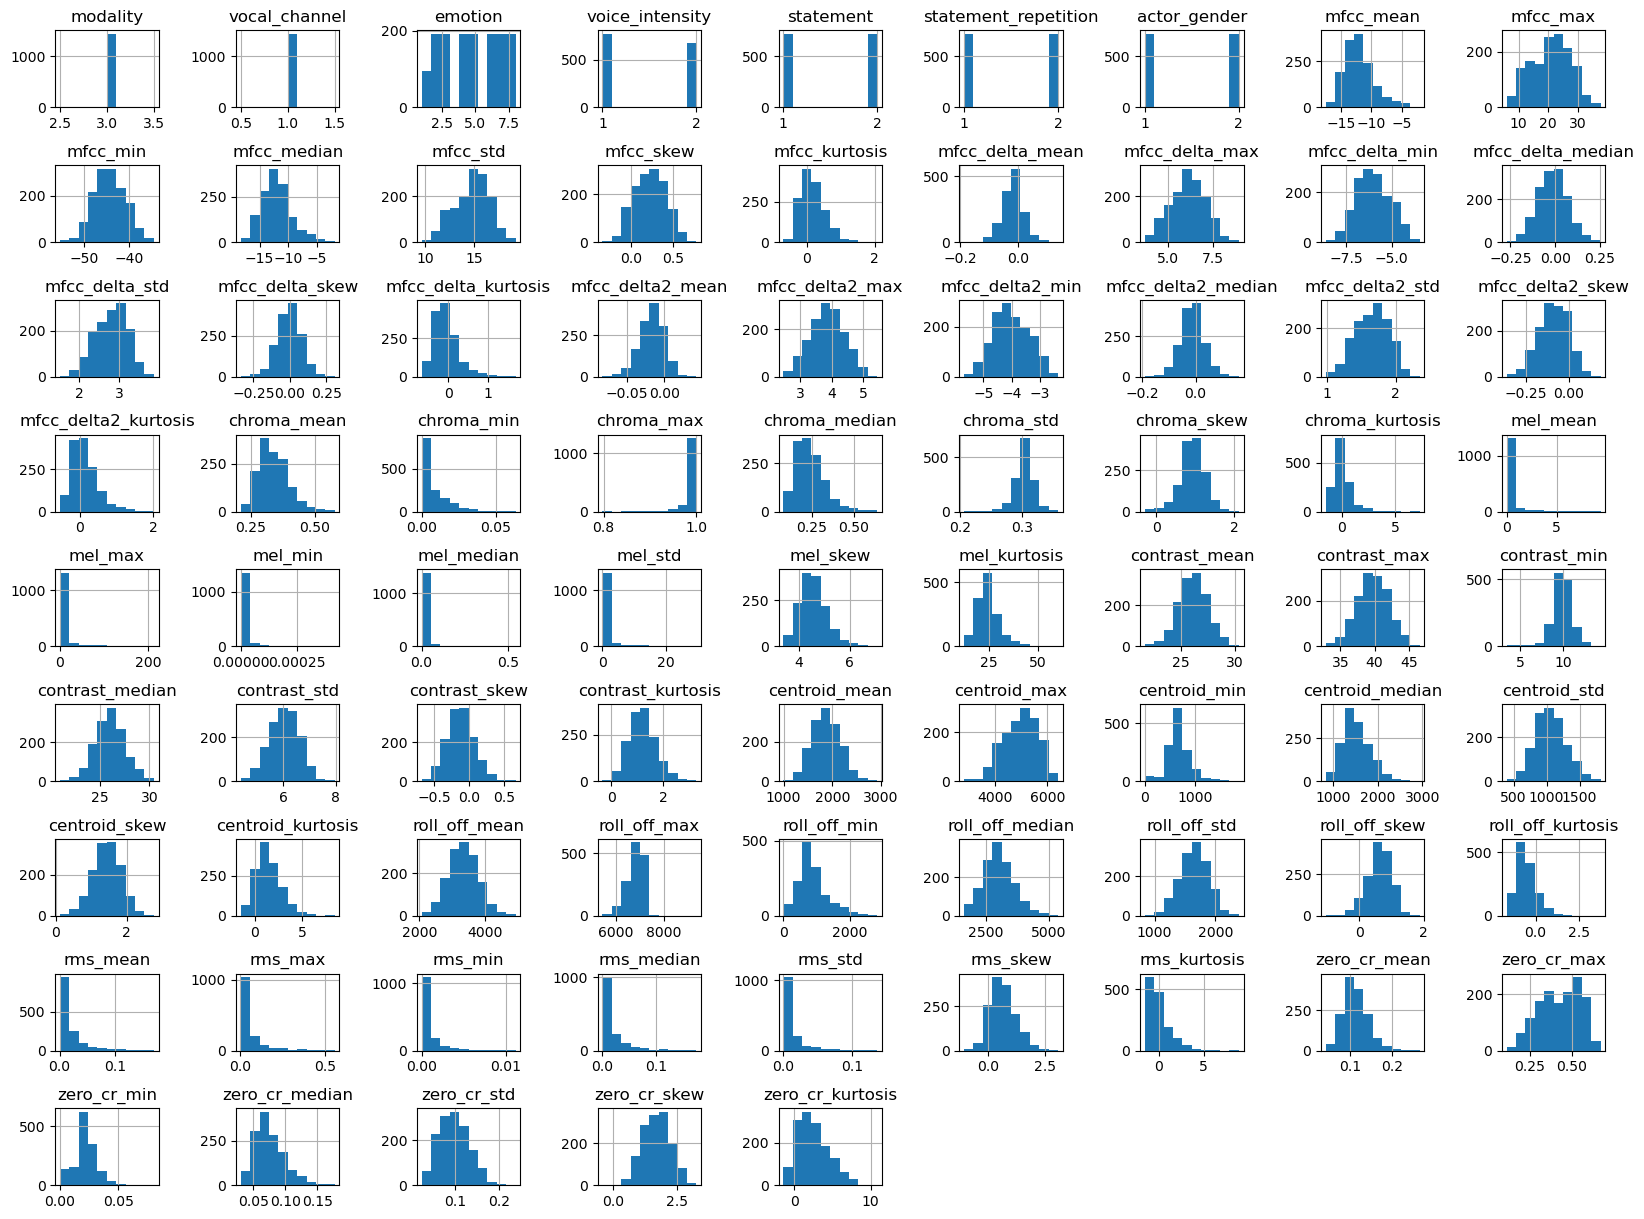

In [32]:
df.hist(figsize=(20,15))
plt.subplots_adjust(hspace=0.75, wspace=0.75);

### Numeric data summary<a id='Numeric_data_summary'></a>

In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
modality,1440.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
vocal_channel,1440.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
emotion,1440.0,4.733333,2.175356,1.000000,3.000000,5.000000,7.000000,8.000000
voice_intensity,1440.0,1.466667,0.499061,1.000000,1.000000,1.000000,2.000000,2.000000
statement,1440.0,1.500000,0.500174,1.000000,1.000000,1.500000,2.000000,2.000000
...,...,...,...,...,...,...,...,...
zero_cr_min,1440.0,0.021941,0.010763,0.000000,0.017090,0.021484,0.027344,0.080566
zero_cr_median,1440.0,0.075499,0.023510,0.030273,0.058838,0.071777,0.088867,0.177246
zero_cr_std,1440.0,0.097521,0.034044,0.023230,0.071471,0.095439,0.120417,0.238526
zero_cr_skew,1440.0,1.705444,0.540598,-0.416989,1.296816,1.728150,2.090271,3.264091


## Exporting DataFrame<a id='Exporting_DataFrame'></a>

In [42]:
# Exporting to CSV files
df.to_csv('voice_data_no_trim.csv', index=False)
# df_f.to_csv('voice_data_dw_f.csv', index=False)

## Summary

The tests were successful and I was able to successfully import the files into a dataframe.  With a little examination 
of the features I was able to extract we can see an even number of male versus female actors. Same goes fort the repetition
of statements but the intensity was sqewed but that is understandable since the 'neutral' emotion does not have a 'strong'
intensity so there are less of them. I decided not to downsample the audio files upon further research. 16000 Hz seems to be 
the minimum standard for voice data and I'd prefer not to compromise the later model's ability to accurately predict 
emotions because of a reduction in quality. Next step is Exploratory Data Analysis and I'm excited to see what patterns arise.